<a href="https://colab.research.google.com/github/zen138yanatib/Zenlab18/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten,  BatchNormalization, Dropout  
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
!pip install split-folders
import splitfolders
import random
import sys 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Data

In [5]:
IM_SIZE = 256   
BATCH_SIZE = 40  

In [8]:
seed = random.randint(0 , sys.maxsize) 
input_folder = "/content/drive/MyDrive/dataset/Dataset"  
output = "splitted-dataset-food/" 
splitfolders.ratio(input_folder, output=output, seed=seed, ratio=(.8, .1, .1))

Copying files: 28 files [00:14,  1.97 files/s]


In [9]:
datagen = ImageDataGenerator(rescale=1./255,
                      brightness_range=[0.9,1.1],
                      width_shift_range=0.1,
                      height_shift_range=0.2,
                      zoom_range=0.3,
                      fill_mode='nearest')


train_generator = datagen.flow_from_directory(  
    '/content/splitted-dataset-food/train',  
    shuffle=True,
    target_size=(IM_SIZE,IM_SIZE),
    batch_size=BATCH_SIZE, 
    color_mode = 'rgb',
    class_mode='categorical')

validation_generator = datagen.flow_from_directory( 
    '/content/splitted-dataset-food/val',
    shuffle=False,
    target_size=(IM_SIZE,IM_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical')

test_generator = datagen.flow_from_directory( 
    '/content/splitted-dataset-food/test',  
    shuffle=False,
    target_size=(IM_SIZE,IM_SIZE),
    batch_size=BATCH_SIZE,  
    color_mode='rgb',
    class_mode='categorical')

Found 22 images belonging to 4 classes.
Found 2 images belonging to 4 classes.
Found 4 images belonging to 4 classes.


Model from scratch

In [10]:
input = Input(shape = (IM_SIZE,IM_SIZE,3))  

conv = Conv2D(128,3,activation='relu')(input)
pool = MaxPool2D()(conv)
conv = Conv2D(128,3,activation='relu')(pool)
conv = Conv2D(128,3,activation='relu')(conv)
pool = MaxPool2D()(conv)
dense = Dropout(0.3)(pool)
conv = Conv2D(256,3,activation='relu')(dense)
conv = Conv2D(256,3,activation='relu')(conv)
pool = MaxPool2D()(conv)
dense = Dropout(0.3)(pool)
conv = Conv2D(256,3,activation='relu')(dense)
pool = MaxPool2D()(conv)
dense = Dropout(0.3)(pool)
conv = Conv2D(256,3,activation='relu')(dense)
pool = MaxPool2D()(conv)
flat = Flatten()(pool)
dense = Dense(256,activation='relu')(flat)
dense = Dropout(0.5)(dense)
dense = Dense(128, activation='relu')(dense)
dense = Dropout(0.2)(dense)
output = Dense(4, activation='softmax')(dense)   
model = Model(inputs=input, outputs=output)   

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 123, 123, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 128)      0         
 2D)                                                         

Training model

<ipython-input-11-7a46c96927e7>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model.fit_generator(


Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 1.4931 - accuracy: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to model-v2.h5
1/1 [==============================] - 35s 35s/step - loss: 1.4931 - accuracy: 0.0000e+00 - val_loss: 1.4000 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 1.4762 - accuracy: 0.0000e+00
Epoch 2: val_accuracy did not improve from 0.00000
1/1 [==============================] - 31s 31s/step - loss: 1.4762 - accuracy: 0.0000e+00 - val_loss: 1.3933 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 1.4457 - accuracy: 0.0455
Epoch 3: val_accuracy did not improve from 0.00000
1/1 [==============================] - 31s 31s/step - loss: 1.4457 - accuracy: 0.0455 - val_loss: 1.3862 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 1.4495 - accuracy: 0.0909
Epoch 4: val_accuracy did not improve

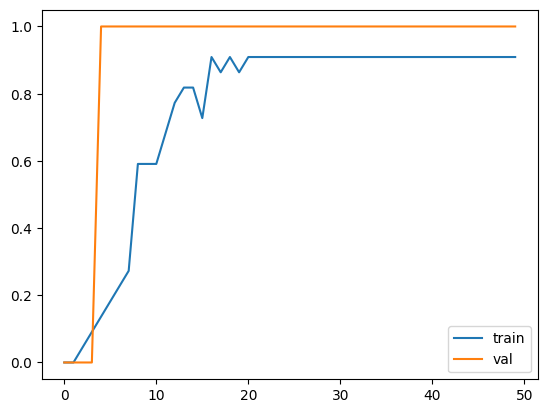

In [11]:
checkpoint = ModelCheckpoint('model-v2.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='max') 


h = model.fit_generator(
    train_generator,
    epochs=50, 
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,   
    validation_steps=len(validation_generator),
    callbacks=[checkpoint])

#graph
plt.plot(h.history['accuracy'], label='accuracy')
plt.plot(h.history['val_accuracy'], label='val_accuracy')
plt.legend(['train','val'])
plt.show()

In [14]:
model = load_model('model-v2.h5')
score = model.evaluate_generator(
    test_generator,
    steps=len(test_generator))
print('score (cross_entropy, accuracy):\n',score)

<ipython-input-14-c7335160e294>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(


score (cross_entropy, accuracy):
 [1.3835899829864502, 0.5]


Read file

In [16]:
IMAGE_SIZE = (IM_SIZE,IM_SIZE)  

model = load_model('model-v2.h5') 

f = open("/content/drive/MyDrive/dataset/filelist.txt", "r") 
file_data = f.read()
all = file_data.splitlines()

o = open('result.txt','w')  

for i in all:
  img = '/content/drive/MyDrive/dataset/filelist/'+i  
  test_im = cv2.imread(img, cv2.IMREAD_COLOR)
  test_im = cv2.cvtColor(test_im, cv2.COLOR_BGR2RGB)
  test_im = cv2.resize(test_im, IMAGE_SIZE)
  test_im = test_im / 255.
  test_im = np.expand_dims(test_im, axis=0)
  w_pred = model.predict(test_im)
  predict_class_idx = np.argmax(w_pred,axis = -1)
  mapping = dict((v,k) for k,v in test_generator.class_indices.items())
  predict_class_name = [mapping[x] for x in predict_class_idx]
  o.write(i+ "::"+ predict_class_name[0][0]+'\n'  )  #write text in result.txt
#   print(i+ "::"+ predict_class_name[0][0])

o.close()

FileNotFoundError: ignored